*https://www.analyticsvidhya.com/blog/2020/11/attention-mechanism-for-caption-generation/*

In [ ]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

import os
import pickle
import numpy as np  
import pandas as pd  

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Embedding, add

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plte

import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_path = "/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/BanglaLekhaImageCaptions/images/"
captions_dir = "/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/BanglaLekhaImageCaptions/"
feature_dir = '/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning'
pngs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(pngs)))

Total Images in Dataset = 18307


In [ ]:
#LOAD FEATURES
with open(os.path.join(feature_dir, 'bangla_features.pkl'),'rb') as f:
  features = pickle.load(f)

len(features)

9154

In [ ]:
with open(os.path.join(captions_dir, 'captions.txt'),'r') as f:
  next(f)
  captions_doc = f.read()

#CHECK
captions_doc

'1.png,একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে একটি বেত নিয়ে পিটানোর ভাব দেখাচ্ছে আর ছোট একটি মেয়ে পিছনে ব্যাগ নিয়ে বসে কাঁদছে।\n2.png,জলাশয় এ একজন ছেলে মানুষ ও একটি বাচ্চা মানুষ আছে। তাদের পিছনে সবুজ গাছ আছে।\n2.png,২ জন মানুষ যার একজন পুরুষ একটি নৌকায় দাড়িয়ে চালাচ্ছে সাদা লুঙ্গী ছাই রঙের গেঞ্জি পরে আরেকজন ছোট ছেলে পার থেকে ধাক্কা দিচ্ছে নউকাতিকে যার পরনে ফুল প্যান্ট খালি গা।\n3.png,অনেক মেয়ে মানুষ বসে আছে।\n3.png,একটি নীল জামা পরা মহিলা একটি নীল ল্যাপটপ এর দিকে তাকিয়ে আছে এবং পিছনে তার দিকে বসে শারি পরে তাকিয়ে আছে অনেকগুলো মহিলা।\n4.png,অনেক মানুষ একসাথে বসে কাজ করছে।\n4.png,২ টি ছোট ছেলে একজন শার্ট প্যান্ট দাড়িয়ে চেয়ে আছে আরেকজন বসে গার্মেন্টস এ কাজ করছে নীল শার্ট পরে তাদের পিছনে অনেকগুলো মহিলা বসে দাড়িয়ে কাজ করছে।\n5.png,ছয় জন মানুষ দাড়িয়ে আছে।\n5.png,৬ জন মানুষ এলোমেলো দাড়িয়ে আছে,তাদের মাঝে ২ জন ছেলে ৪ জন পুরুষ,তাদের একজন লুঙ্গী পরে দাড়িয়ে আছে।\n6.png,এক জন মেয়ে মানুষ মাথায় ঘোমটা দিয়ে কাজ করছে। মাটিতে বিভিন্ন রঙের মসলা আছে।\n6.png,একটি মহিলা হালকা পানির উপরে দাড়িয়ে আছে শারি প

In [ ]:
mapping = {}
# PROCESS LINE
for line in tqdm(captions_doc.split('\n')):
  #SPLIT THE LINE BY COMMA
  tokens = line.split(',')
  if len(line) <2:
    continue
  image_id, caption = tokens[0], tokens[1:]
  #REMOVE EXTENSION FROM IMAGE ID
  image_id = image_id.split('.')[0]
  #CONVERT CAPTION LIST TO STRING
  caption = " ".join(caption)
  #CREATE LIST IF NEED
  if image_id not in mapping:
    mapping[image_id] = []
  mapping[image_id].append(caption)

100%|██████████| 18307/18307 [00:00<00:00, 92005.61it/s]


In [ ]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      caption = captions[i] #TAKE ONE CAPTION AT A TIME
      #PREPROCESSING STEPS
      caption = caption.replace('\s+',' ') #DELETE ADDITIONAL SPACES
      #ADD START AND TAGS TO THE CAPTIONS
      #caption = '<start> ' + caption + ' <end>' #HELP'S TO START AND STOP PREDICITON, END TAG HELPS TO STOP
      caption = '<start> ' + " ".join(word for word in caption.split() if len(word)) + ' <end>' #remove small first word such as 'a'
      captions[i] = caption

In [ ]:
mapping['2']

['জলাশয় এ একজন ছেলে মানুষ ও একটি বাচ্চা মানুষ আছে। তাদের পিছনে সবুজ গাছ আছে।',
 '২ জন মানুষ যার একজন পুরুষ একটি নৌকায় দাড়িয়ে চালাচ্ছে সাদা লুঙ্গী ছাই রঙের গেঞ্জি পরে আরেকজন ছোট ছেলে পার থেকে ধাক্কা দিচ্ছে নউকাতিকে যার পরনে ফুল প্যান্ট খালি গা।']

In [ ]:
clean(mapping)

In [ ]:
mapping['4444']

['<start> সবুজ জামা পরিহিত তিনজন ও কালো জামা পরিহিত একজন পাশাপাশি দাড়িয়ে আছে। <end>',
 '<start> চারজন লোক এক সাথে হয়ে ছবি তুলছে পিছনে কয়েকটা পোস্টা দেখা যাচ্ছে। <end>']

In [ ]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

#check
print(len(features))
print(len(all_captions))
all_captions[:10]

9154
18307


['<start> একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে একটি বেত নিয়ে পিটানোর ভাব দেখাচ্ছে আর ছোট একটি মেয়ে পিছনে ব্যাগ নিয়ে বসে কাঁদছে। <end>',
 '<start> জলাশয় এ একজন ছেলে মানুষ ও একটি বাচ্চা মানুষ আছে। তাদের পিছনে সবুজ গাছ আছে। <end>',
 '<start> ২ জন মানুষ যার একজন পুরুষ একটি নৌকায় দাড়িয়ে চালাচ্ছে সাদা লুঙ্গী ছাই রঙের গেঞ্জি পরে আরেকজন ছোট ছেলে পার থেকে ধাক্কা দিচ্ছে নউকাতিকে যার পরনে ফুল প্যান্ট খালি গা। <end>',
 '<start> অনেক মেয়ে মানুষ বসে আছে। <end>',
 '<start> একটি নীল জামা পরা মহিলা একটি নীল ল্যাপটপ এর দিকে তাকিয়ে আছে এবং পিছনে তার দিকে বসে শারি পরে তাকিয়ে আছে অনেকগুলো মহিলা। <end>',
 '<start> অনেক মানুষ একসাথে বসে কাজ করছে। <end>',
 '<start> ২ টি ছোট ছেলে একজন শার্ট প্যান্ট দাড়িয়ে চেয়ে আছে আরেকজন বসে গার্মেন্টস এ কাজ করছে নীল শার্ট পরে তাদের পিছনে অনেকগুলো মহিলা বসে দাড়িয়ে কাজ করছে। <end>',
 '<start> ছয় জন মানুষ দাড়িয়ে আছে। <end>',
 '<start> ৬ জন মানুষ এলোমেলো দাড়িয়ে আছে তাদের মাঝে ২ জন ছেলে ৪ জন পুরুষ তাদের একজন লুঙ্গী পরে দাড়িয়ে আছে। <end>',
 '<start> এক জন মেয়ে মানুষ মাথায় ঘ

In [ ]:
all_img_name_vector = []

for image_id in mapping:
  for key in mapping[image_id]:
    image = image_path + image_id + '.png'
    all_img_name_vector.append(image)

all_img_name_vector[:10]

['/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/BanglaLekhaImageCaptions/images/1.png',
 '/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/BanglaLekhaImageCaptions/images/2.png',
 '/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/BanglaLekhaImageCaptions/images/2.png',
 '/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/BanglaLekhaImageCaptions/images/3.png',
 '/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/BanglaLekhaImageCaptions/images/3.png',
 '/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/BanglaLekhaImageCaptions/images/4.png',
 '/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/BanglaLekhaImageCaptions/images/4.png',
 '/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/BanglaLekhaImageCaptions/images/5.png',
 '/content/drive/MyDrive

In [ ]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 18307
len(all_captions) : 18307


In [ ]:
# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 16000 captions from the shuffled set
num_examples = 18000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index)+1

vocab_size #CHECK

5739

In [ ]:
len(train_captions), len(all_captions)

(18000, 18307)

In [ ]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

##convert to Numpy file

In [ ]:
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())


100%|██████████| 572/572 [29:44<00:00,  3.12s/it]


In [ ]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
max_length = calc_max_length(train_seqs)

In [ ]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

print(len(img_name_val))

3600


In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(14400, 14400, 3600, 3600)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

In [ ]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

##Model

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

##Train and optimize

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 50

for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 1.8913
Epoch 1 Batch 100 Loss 1.1436
Epoch 1 Batch 200 Loss 0.9465


  2%|▏         | 1/50 [04:22<3:34:03, 262.12s/it]

Epoch 1 Loss 1.176259
Time taken for 1 epoch 262.11997628211975 sec

Epoch 2 Batch 0 Loss 1.0203
Epoch 2 Batch 100 Loss 0.8754
Epoch 2 Batch 200 Loss 0.8441


  4%|▍         | 2/50 [05:01<1:44:44, 130.93s/it]

Epoch 2 Loss 0.867237
Time taken for 1 epoch 39.103277921676636 sec

Epoch 3 Batch 0 Loss 0.8254
Epoch 3 Batch 100 Loss 0.7534
Epoch 3 Batch 200 Loss 0.7786


  6%|▌         | 3/50 [05:43<1:10:53, 90.50s/it] 

Epoch 3 Loss 0.766534
Time taken for 1 epoch 42.372503995895386 sec

Epoch 4 Batch 0 Loss 0.8107
Epoch 4 Batch 100 Loss 0.6539
Epoch 4 Batch 200 Loss 0.5811


  8%|▊         | 4/50 [06:22<53:51, 70.25s/it]  

Epoch 4 Loss 0.695928
Time taken for 1 epoch 39.21298289299011 sec

Epoch 5 Batch 0 Loss 0.5801
Epoch 5 Batch 100 Loss 0.6249
Epoch 5 Batch 200 Loss 0.5238


 10%|█         | 5/50 [07:01<44:08, 58.86s/it]

Epoch 5 Loss 0.636633
Time taken for 1 epoch 38.671486139297485 sec

Epoch 6 Batch 0 Loss 0.5398
Epoch 6 Batch 100 Loss 0.6067
Epoch 6 Batch 200 Loss 0.6324


 12%|█▏        | 6/50 [07:40<38:20, 52.28s/it]

Epoch 6 Loss 0.580940
Time taken for 1 epoch 39.4890410900116 sec

Epoch 7 Batch 0 Loss 0.5585
Epoch 7 Batch 100 Loss 0.5442
Epoch 7 Batch 200 Loss 0.4784


 14%|█▍        | 7/50 [08:20<34:21, 47.95s/it]

Epoch 7 Loss 0.531294
Time taken for 1 epoch 39.02787661552429 sec

Epoch 8 Batch 0 Loss 0.5927
Epoch 8 Batch 100 Loss 0.5054
Epoch 8 Batch 200 Loss 0.4427


 16%|█▌        | 8/50 [08:59<31:37, 45.18s/it]

Epoch 8 Loss 0.486178
Time taken for 1 epoch 39.24735879898071 sec

Epoch 9 Batch 0 Loss 0.4525
Epoch 9 Batch 100 Loss 0.3585
Epoch 9 Batch 200 Loss 0.4313


 18%|█▊        | 9/50 [09:38<29:37, 43.35s/it]

Epoch 9 Loss 0.445121
Time taken for 1 epoch 39.31660604476929 sec

Epoch 10 Batch 0 Loss 0.4725
Epoch 10 Batch 100 Loss 0.4601
Epoch 10 Batch 200 Loss 0.3695


 20%|██        | 10/50 [10:17<28:01, 42.04s/it]

Epoch 10 Loss 0.407872
Time taken for 1 epoch 39.113783836364746 sec

Epoch 11 Batch 0 Loss 0.4499
Epoch 11 Batch 100 Loss 0.3849
Epoch 11 Batch 200 Loss 0.4370


 22%|██▏       | 11/50 [10:57<26:47, 41.22s/it]

Epoch 11 Loss 0.373615
Time taken for 1 epoch 39.365116596221924 sec

Epoch 12 Batch 0 Loss 0.3825
Epoch 12 Batch 100 Loss 0.3795
Epoch 12 Batch 200 Loss 0.3022


 24%|██▍       | 12/50 [11:35<25:39, 40.52s/it]

Epoch 12 Loss 0.342508
Time taken for 1 epoch 38.92480134963989 sec

Epoch 13 Batch 0 Loss 0.3525
Epoch 13 Batch 100 Loss 0.3065
Epoch 13 Batch 200 Loss 0.3069


 26%|██▌       | 13/50 [12:14<24:40, 40.02s/it]

Epoch 13 Loss 0.312932
Time taken for 1 epoch 38.842116355895996 sec

Epoch 14 Batch 0 Loss 0.4035
Epoch 14 Batch 100 Loss 0.2828
Epoch 14 Batch 200 Loss 0.3104


 28%|██▊       | 14/50 [12:53<23:45, 39.59s/it]

Epoch 14 Loss 0.288483
Time taken for 1 epoch 38.59023976325989 sec

Epoch 15 Batch 0 Loss 0.3224
Epoch 15 Batch 100 Loss 0.2588
Epoch 15 Batch 200 Loss 0.2465


 30%|███       | 15/50 [13:32<22:56, 39.34s/it]

Epoch 15 Loss 0.264960
Time taken for 1 epoch 38.761088132858276 sec

Epoch 16 Batch 0 Loss 0.2512
Epoch 16 Batch 100 Loss 0.2026
Epoch 16 Batch 200 Loss 0.2055


 32%|███▏      | 16/50 [14:11<22:13, 39.22s/it]

Epoch 16 Loss 0.241893
Time taken for 1 epoch 38.93778896331787 sec

Epoch 17 Batch 0 Loss 0.2684
Epoch 17 Batch 100 Loss 0.2258
Epoch 17 Batch 200 Loss 0.1716


 34%|███▍      | 17/50 [14:50<21:31, 39.13s/it]

Epoch 17 Loss 0.223809
Time taken for 1 epoch 38.92219138145447 sec

Epoch 18 Batch 0 Loss 0.2421
Epoch 18 Batch 100 Loss 0.2092
Epoch 18 Batch 200 Loss 0.1616


 36%|███▌      | 18/50 [15:28<20:46, 38.94s/it]

Epoch 18 Loss 0.207055
Time taken for 1 epoch 38.508845806121826 sec

Epoch 19 Batch 0 Loss 0.2430
Epoch 19 Batch 100 Loss 0.1907
Epoch 19 Batch 200 Loss 0.1689


 38%|███▊      | 19/50 [16:07<20:02, 38.80s/it]

Epoch 19 Loss 0.191685
Time taken for 1 epoch 38.45543885231018 sec

Epoch 20 Batch 0 Loss 0.2576
Epoch 20 Batch 100 Loss 0.1652
Epoch 20 Batch 200 Loss 0.1682


 40%|████      | 20/50 [16:45<19:23, 38.78s/it]

Epoch 20 Loss 0.178015
Time taken for 1 epoch 38.74976587295532 sec

Epoch 21 Batch 0 Loss 0.1854
Epoch 21 Batch 100 Loss 0.1629
Epoch 21 Batch 200 Loss 0.1292


 42%|████▏     | 21/50 [17:24<18:45, 38.82s/it]

Epoch 21 Loss 0.166966
Time taken for 1 epoch 38.88211512565613 sec

Epoch 22 Batch 0 Loss 0.2186
Epoch 22 Batch 100 Loss 0.1715
Epoch 22 Batch 200 Loss 0.1672


 44%|████▍     | 22/50 [18:03<18:05, 38.77s/it]

Epoch 22 Loss 0.158071
Time taken for 1 epoch 38.65255928039551 sec

Epoch 23 Batch 0 Loss 0.1851
Epoch 23 Batch 100 Loss 0.1588
Epoch 23 Batch 200 Loss 0.1368


 46%|████▌     | 23/50 [18:42<17:27, 38.79s/it]

Epoch 23 Loss 0.148002
Time taken for 1 epoch 38.85028386116028 sec

Epoch 24 Batch 0 Loss 0.1876
Epoch 24 Batch 100 Loss 0.1276
Epoch 24 Batch 200 Loss 0.1116


 48%|████▊     | 24/50 [19:20<16:46, 38.70s/it]

Epoch 24 Loss 0.137265
Time taken for 1 epoch 38.48490619659424 sec

Epoch 25 Batch 0 Loss 0.1386
Epoch 25 Batch 100 Loss 0.1530
Epoch 25 Batch 200 Loss 0.1371


 50%|█████     | 25/50 [19:59<16:05, 38.63s/it]

Epoch 25 Loss 0.130821
Time taken for 1 epoch 38.46432280540466 sec

Epoch 26 Batch 0 Loss 0.1767
Epoch 26 Batch 100 Loss 0.1527
Epoch 26 Batch 200 Loss 0.1293


 52%|█████▏    | 26/50 [20:37<15:27, 38.64s/it]

Epoch 26 Loss 0.125914
Time taken for 1 epoch 38.642083168029785 sec

Epoch 27 Batch 0 Loss 0.1562
Epoch 27 Batch 100 Loss 0.1079
Epoch 27 Batch 200 Loss 0.0971


 54%|█████▍    | 27/50 [21:16<14:46, 38.55s/it]

Epoch 27 Loss 0.122029
Time taken for 1 epoch 38.3453369140625 sec

Epoch 28 Batch 0 Loss 0.1012
Epoch 28 Batch 100 Loss 0.1264
Epoch 28 Batch 200 Loss 0.0863


 56%|█████▌    | 28/50 [21:55<14:16, 38.92s/it]

Epoch 28 Loss 0.114542
Time taken for 1 epoch 39.78761148452759 sec

Epoch 29 Batch 0 Loss 0.1371
Epoch 29 Batch 100 Loss 0.1126
Epoch 29 Batch 200 Loss 0.1023


 58%|█████▊    | 29/50 [22:35<13:42, 39.18s/it]

Epoch 29 Loss 0.110924
Time taken for 1 epoch 39.763166427612305 sec

Epoch 30 Batch 0 Loss 0.1577
Epoch 30 Batch 100 Loss 0.1099
Epoch 30 Batch 200 Loss 0.0977


 60%|██████    | 30/50 [23:14<12:59, 38.95s/it]

Epoch 30 Loss 0.106618
Time taken for 1 epoch 38.43000936508179 sec

Epoch 31 Batch 0 Loss 0.1436
Epoch 31 Batch 100 Loss 0.1202
Epoch 31 Batch 200 Loss 0.1166


 62%|██████▏   | 31/50 [23:52<12:18, 38.89s/it]

Epoch 31 Loss 0.103570
Time taken for 1 epoch 38.73870372772217 sec

Epoch 32 Batch 0 Loss 0.1258
Epoch 32 Batch 100 Loss 0.0867
Epoch 32 Batch 200 Loss 0.0993


 64%|██████▍   | 32/50 [24:31<11:38, 38.78s/it]

Epoch 32 Loss 0.100342
Time taken for 1 epoch 38.523725271224976 sec

Epoch 33 Batch 0 Loss 0.1323
Epoch 33 Batch 100 Loss 0.0952
Epoch 33 Batch 200 Loss 0.1274


 66%|██████▌   | 33/50 [25:10<10:59, 38.79s/it]

Epoch 33 Loss 0.097430
Time taken for 1 epoch 38.79547476768494 sec

Epoch 34 Batch 0 Loss 0.1091
Epoch 34 Batch 100 Loss 0.0879
Epoch 34 Batch 200 Loss 0.0786


 68%|██████▊   | 34/50 [25:48<10:19, 38.74s/it]

Epoch 34 Loss 0.097261
Time taken for 1 epoch 38.641746520996094 sec

Epoch 35 Batch 0 Loss 0.1119
Epoch 35 Batch 100 Loss 0.1149
Epoch 35 Batch 200 Loss 0.0953


 70%|███████   | 35/50 [26:27<09:39, 38.64s/it]

Epoch 35 Loss 0.094722
Time taken for 1 epoch 38.40490245819092 sec

Epoch 36 Batch 0 Loss 0.1314
Epoch 36 Batch 100 Loss 0.1017
Epoch 36 Batch 200 Loss 0.0791


 72%|███████▏  | 36/50 [27:05<09:00, 38.64s/it]

Epoch 36 Loss 0.092750
Time taken for 1 epoch 38.63356876373291 sec

Epoch 37 Batch 0 Loss 0.1088
Epoch 37 Batch 100 Loss 0.0886
Epoch 37 Batch 200 Loss 0.0995


 74%|███████▍  | 37/50 [27:44<08:23, 38.72s/it]

Epoch 37 Loss 0.090588
Time taken for 1 epoch 38.87898874282837 sec

Epoch 38 Batch 0 Loss 0.1008
Epoch 38 Batch 100 Loss 0.0886
Epoch 38 Batch 200 Loss 0.0929


 76%|███████▌  | 38/50 [28:23<07:43, 38.59s/it]

Epoch 38 Loss 0.087563
Time taken for 1 epoch 38.28409957885742 sec

Epoch 39 Batch 0 Loss 0.1286
Epoch 39 Batch 100 Loss 0.0811
Epoch 39 Batch 200 Loss 0.0823


 78%|███████▊  | 39/50 [29:01<07:04, 38.61s/it]

Epoch 39 Loss 0.085894
Time taken for 1 epoch 38.66729974746704 sec

Epoch 40 Batch 0 Loss 0.1198
Epoch 40 Batch 100 Loss 0.0851
Epoch 40 Batch 200 Loss 0.0920


 80%|████████  | 40/50 [29:40<06:26, 38.61s/it]

Epoch 40 Loss 0.084403
Time taken for 1 epoch 38.5926296710968 sec

Epoch 41 Batch 0 Loss 0.1162
Epoch 41 Batch 100 Loss 0.0742
Epoch 41 Batch 200 Loss 0.0883


 82%|████████▏ | 41/50 [30:19<05:48, 38.71s/it]

Epoch 41 Loss 0.085281
Time taken for 1 epoch 38.95635390281677 sec

Epoch 42 Batch 0 Loss 0.1104
Epoch 42 Batch 100 Loss 0.0876
Epoch 42 Batch 200 Loss 0.0889


 84%|████████▍ | 42/50 [30:57<05:09, 38.66s/it]

Epoch 42 Loss 0.082575
Time taken for 1 epoch 38.549118518829346 sec

Epoch 43 Batch 0 Loss 0.0995
Epoch 43 Batch 100 Loss 0.0893
Epoch 43 Batch 200 Loss 0.0966


 86%|████████▌ | 43/50 [31:36<04:30, 38.67s/it]

Epoch 43 Loss 0.081569
Time taken for 1 epoch 38.68831419944763 sec

Epoch 44 Batch 0 Loss 0.1216
Epoch 44 Batch 100 Loss 0.0822
Epoch 44 Batch 200 Loss 0.0800


 88%|████████▊ | 44/50 [32:15<03:52, 38.81s/it]

Epoch 44 Loss 0.080696
Time taken for 1 epoch 39.14493536949158 sec

Epoch 45 Batch 0 Loss 0.1100
Epoch 45 Batch 100 Loss 0.0903
Epoch 45 Batch 200 Loss 0.0785


 90%|█████████ | 45/50 [32:54<03:13, 38.77s/it]

Epoch 45 Loss 0.078986
Time taken for 1 epoch 38.67982459068298 sec

Epoch 46 Batch 0 Loss 0.1037
Epoch 46 Batch 100 Loss 0.0702
Epoch 46 Batch 200 Loss 0.0811


 92%|█████████▏| 46/50 [33:33<02:35, 38.91s/it]

Epoch 46 Loss 0.078754
Time taken for 1 epoch 39.21239376068115 sec

Epoch 47 Batch 0 Loss 0.0881
Epoch 47 Batch 100 Loss 0.0758
Epoch 47 Batch 200 Loss 0.0766


 94%|█████████▍| 47/50 [34:12<01:56, 38.78s/it]

Epoch 47 Loss 0.078450
Time taken for 1 epoch 38.49792218208313 sec

Epoch 48 Batch 0 Loss 0.0990
Epoch 48 Batch 100 Loss 0.0829
Epoch 48 Batch 200 Loss 0.0638


 96%|█████████▌| 48/50 [34:51<01:17, 38.97s/it]

Epoch 48 Loss 0.077503
Time taken for 1 epoch 39.4147834777832 sec

Epoch 49 Batch 0 Loss 0.0939
Epoch 49 Batch 100 Loss 0.0698
Epoch 49 Batch 200 Loss 0.0901


 98%|█████████▊| 49/50 [35:30<00:38, 38.88s/it]

Epoch 49 Loss 0.074469
Time taken for 1 epoch 38.66553068161011 sec

Epoch 50 Batch 0 Loss 0.0791
Epoch 50 Batch 100 Loss 0.0766
Epoch 50 Batch 200 Loss 0.0627


100%|██████████| 50/50 [36:08<00:00, 43.38s/it]

Epoch 50 Loss 0.074289
Time taken for 1 epoch 38.71597075462341 sec



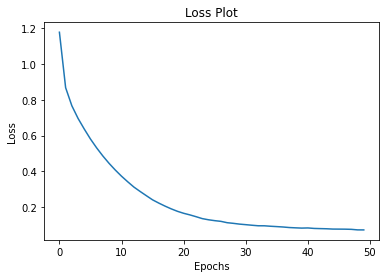

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

##Save wights and word index

In [ ]:
!mkdir "/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/CaptioningModel/"

In [ ]:
import json
with open('/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/CaptioningModel/word_index.json', 'w') as fp:
  json.dump(tokenizer.word_index, fp)
with open('/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/CaptioningModel/index_word.json', 'w') as fp:
  json.dump(tokenizer.index_word, fp)

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/CaptioningModel/decoder"
decoder.save_weights(path)

path = "/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/CaptioningModel/encoder"
encoder.save_weights(path)

##Load wights and word index

In [ ]:
# Load the state of the old model
path = "/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/CaptioningModel/decoder"
decoder.load_weights(path)

path = "/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/CaptioningModel/encoder"
encoder.load_weights(path)

In [ ]:
#run this cell
#loading vocabulary
import json

with open('/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/CaptioningModel/word_index.json', 'r') as fp:
    word_index = json.load(fp)

with open('/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/CaptioningModel/index_word.json', 'r') as fp:
    index_word = json.load(fp)

##Evaluate

In [ ]:
def evaluate(image):
  attention_plot = np.zeros((max_length, attention_features_shape))

  hidden = decoder.reset_state(batch_size=1)

  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

  features = encoder(img_tensor_val)
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
  result = []

  for i in range(max_length):
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
    attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()
    result.append(tokenizer.index_word[predicted_id])

    if tokenizer.index_word[predicted_id] == '<end>':
      return result, attention_plot

    dec_input = tf.expand_dims([predicted_id], 0)
  attention_plot = attention_plot[:len(result), :]
  
  return result, attention_plot

In [ ]:
from matplotlib import font_manager
my_font = font_manager.FontProperties(fname="/content/kalpurush.ttf")

In [ ]:
def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))

   fig = plt.figure(figsize=(10, 10))
   
   len_result = len(result)
   for l in range(len_result):
     try:
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l], fontproperties = my_font)

       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
     except ValueError:
       break


   plt.tight_layout()
   plt.show()

##BELU score evaluate

In [ ]:
# captions on the validation set
import json
real = []
predicted =[]
jsonAnnotation = []
jsonPredected = []
count=0
for i in range(8000):
  rid = np.random.randint(0, len(img_name_val))
  image = img_name_val[rid]
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
  result, attention_plot = evaluate(image)
 
  img =  image[19 : len(image)]
  real_caption = real_caption.replace('<start>', ' ')
  real_caption = real_caption.replace('<end>', ' ')
  ls = {
      "name": str(img),
      "id" : str(rid),
      "caption" : real_caption
  }
  jsonAnnotation.append(ls)


  predictedCaption = ' '.join(result)
  predictedCaption = predictedCaption.replace('<start>', ' ')
  predictedCaption = predictedCaption.replace('<end>', ' ')

  pLs = {
      "image_id": rid ,
      "id":rid,
      "caption":predictedCaption
  }
  count = count +1
  jsonPredected.append(pLs)
  if(count%100 == 0):
    print("Done Steps "+ str((count)))


!mkdir "/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/score"
with open('/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/score/predictedCaption.json', 'w') as fp:
  json.dump(jsonPredected , fp)
with open('/content/drive/MyDrive/Colab Notebooks/IMAGE CAPTIONING/Bangla Image Captioning/score/annotation.json', 'w') as fp:
  json.dump(jsonAnnotation , fp)

print("Done, Uploaded on Drive")
#plot_attention(image, result, attention_plot)
#Image.open(image)

BELU score: 80.91067115702212
Real Caption: সমুদ্রের পারে অনেকগুলো মানুষ দাড়িয়ে আছে।
Prediction Caption: সমুদ্রের বিচে অনেক মানুষ দাঁড়িয়ে আছে।


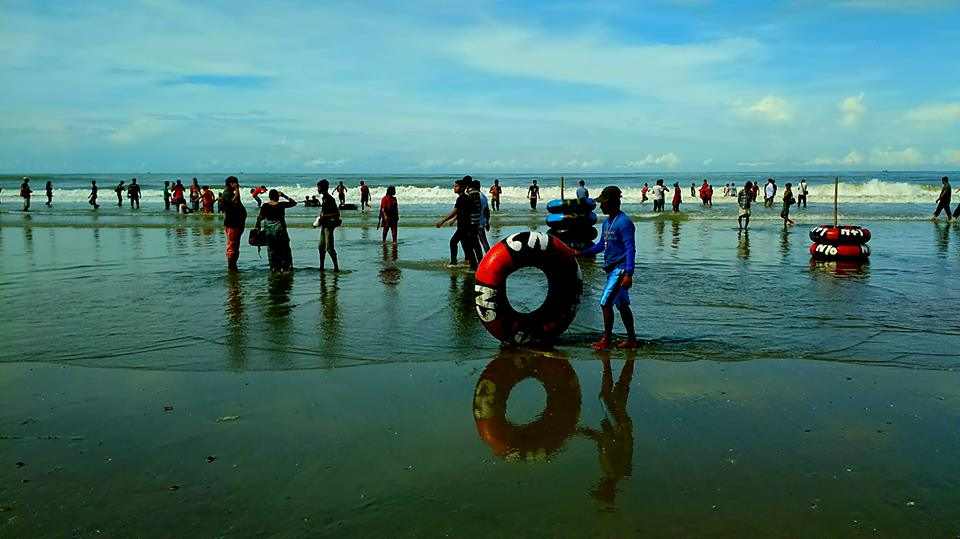

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

#Test image captioning

রাস্তা দিয়ে কুটি চালাচ্ছে যাতে অনেক মানুষ আছে।


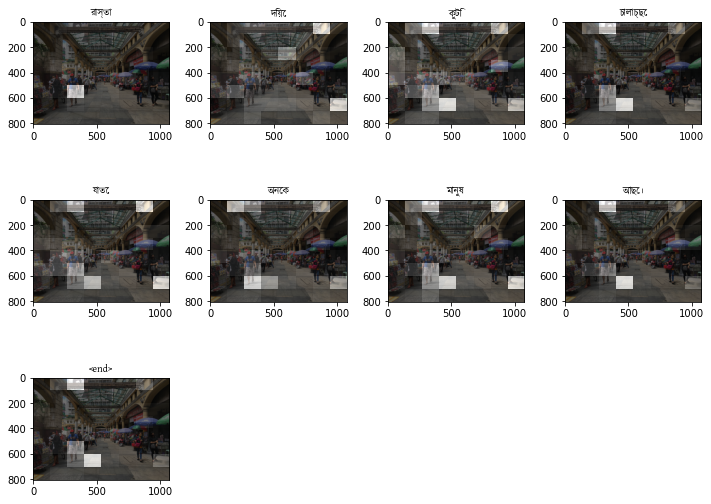

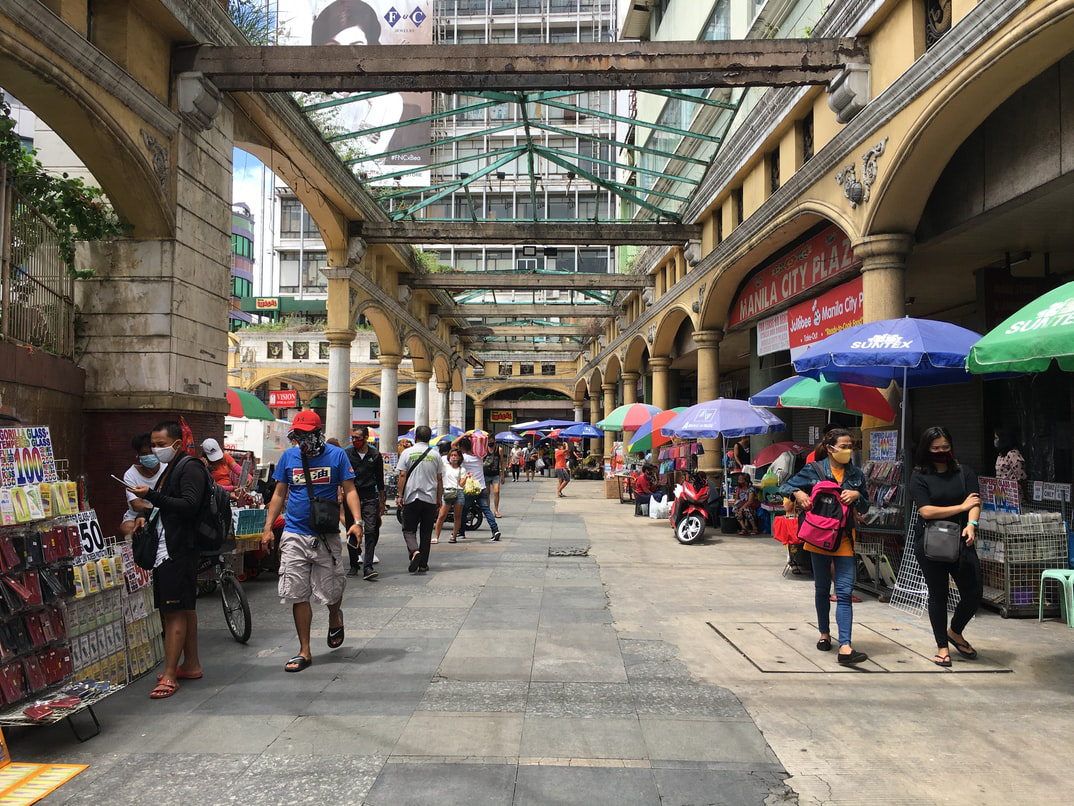

In [ ]:
#local image 
image_path = "/content/next_600.jpg"
result,attention_plot = evaluate(image_path)
predCaption = ' '.join(result)
predCaption = predCaption.rsplit(' ', 1)[0]
print(predCaption)
plot_attention(image_path, result, attention_plot)
Image.open(image_path)
